# SACCR

Background: Starting from January, 2019, OSFI requires all financial institutions measure
Counterparty Credit Risk by new model called Standardised Approach (SACCR).

Related research paper: https://www.bis.org/publ/bcbs279.pdf

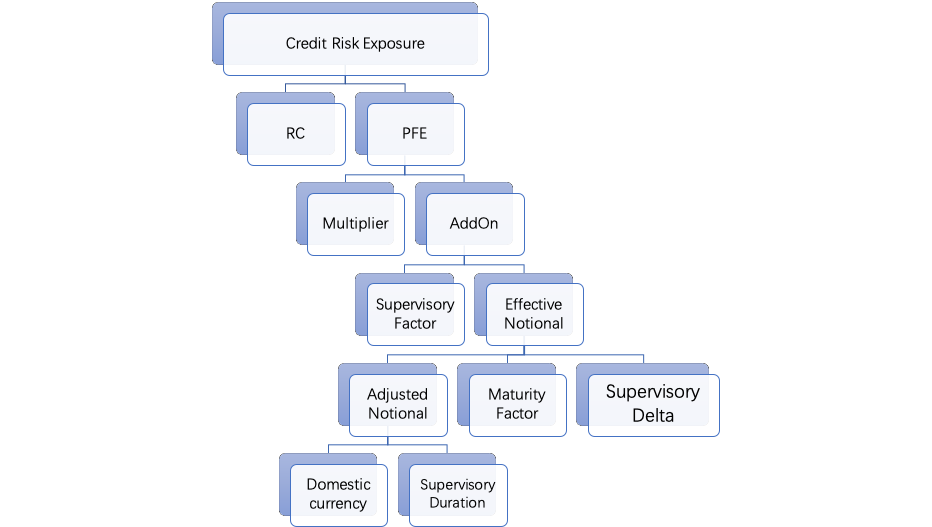

In [1]:
!pip install easymoney

In [2]:
import numpy as np
import pandas as pd
from easymoney.money import EasyPeasy
from scipy.stats import norm
import math

In [3]:
data = pd.read_excel("Interest Rate.xlsx")
data.head()

,TRADE_ID,PRODUCT,HEDGING_SET,START_DATE,END_DATE,TRADE_NOTIONAL,PAY_LEG,RECEIVE_LEG,OPTION TYPE,PRICE,STRIKE,VOLATILITY,SUPERVISORY FACTOR,MTM,COLLATERAL,DELTA
0,1,Interest Rate Swap,USD,0.0,0.1,10000,Fix,Floating,NaN,0.01,NaN,0.5,0.005,3000.0,2000.0,1.0
1,2,Interest Rate Swap,USD,0.0,0.2,20000,Fix,Floating,NaN,0.02,NaN,0.5,0.005,-40000.0,-39000.0,1.0
2,3,Interest Rate Swap,USD,0.0,0.3,30000,Fix,Floating,NaN,0.03,NaN,0.5,0.005,20.0,-980.0,1.0
3,4,Interest Rate Swap,USD,0.0,0.4,40000,Fix,Floating,NaN,0.04,NaN,0.5,0.005,600.0,-400.0,1.0
4,5,Interest Rate Swap,USD,0.0,0.5,50000,Fix,Floating,NaN,0.05,NaN,0.5,0.005,-890.0,110.0,1.0


In [4]:
#convert the notional amount into CAD
ep = EasyPeasy() 
data['DOMESTIC__NOTIONAL'] = data.apply(lambda x: ep.currency_converter(x['TRADE_NOTIONAL'], from_currency=x['HEDGING_SET'], to_currency="CAD"), axis=1)

In [5]:
# In[adjusted_notional]: Calculate Adjusted Notional
def adjusted_notional(table):
    
    """
    This function is to compute adjusted notional amount and supervisory duration
    
    Input: 
        table: netting set infomation
    
    outputs:
        Revised table: with Supervisory Duration and Adjusted Notional added
    """
    
    #abstract start date and end date:
    S = table['START_DATE']
    E = table['END_DATE']
    
    #supervisory duration calculation based on S and E 
    table['SUPERVISORY_DURATION'] = (np.exp(-0.05*np.array(S)) - np.exp(-0.05*np.array(E)))/0.05

    table['ADJUSTED_NOTIONAL'] = table['DOMESTIC__NOTIONAL']*table['SUPERVISORY_DURATION']
    return table

data=data.apply(lambda x: adjusted_notional(x), axis=1)

In [6]:
def Position(df):
    
    """
    Used to determine Buy/Sell Positions for each records
    
    """
    
    # For option product, if we can short primary risk, then we can consider: Buy put
    # For option product, if we can short primary risk, then we can consider: Buy Call
    if (df['OPTION TYPE'] == "PUT" or df['OPTION TYPE'] == "CALL") and \
                             df['START_DATE'] != 0:
        df['POSITION'] = 'BUY'
    
    # For Interest Rate Swap, if we pay fix rate then we consider: buy
    # For Interest Rate Swap, if we pay fix rate then we consider: Sell
    else:
        if df['PAY_LEG'] == 'Fix' and df['RECEIVE_LEG'] == 'Floating':
            df['POSITION'] = 'BUY'
        elif df['PAY_LEG'] == 'Floating' and df['RECEIVE_LEG'] == 'Fix':
            df['POSITION'] = 'SELL'
    
    # In the real situation, we have many special cases.    
        else:
            df['POSITION'] = 'Please Check with Trader'
    
    return df

data=data.apply(lambda x: Position(x), axis=1) 

In [7]:
# In[sup_delta]: Calculate Supervisory Delta
def supervisory_delta(df):
    # calculate delta value according to option's type and position
    if df['PRODUCT'] == 'European swaption' and df['START_DATE'] != 0:
        # Black Shcoles Delta formula only apply for option products
        
        d1 = (np.log(df['PRICE']/df['STRIKE']) + (np.square(df['VOLATILITY'])/2)*\
                          df['START_DATE'])/(df['VOLATILITY']/np.sqrt(df['START_DATE']))
        
        # Calculate Put Supervisory Delta
        if df['OPTION TYPE'] == 'PUT':
            if df['POSITION'] == 'BUY':
                df['SUPERVISORY_DELTA'] = -norm.cdf(-d1)
            else:
                df['SUPERVISORY_DELTA'] = norm.cdf(-d1)
                
        # Calculate Call Supervisory Delta       
        if df['OPTION TYPE'] == 'CALL':
            if df['POSITION'] == 'BUY':
                df['SUPERVISORY_DELTA'] = norm.cdf(d1)
            else:
                df['SUPERVISORY_DELTA'] = -norm.cdf(d1)
    
    # Supervisory Delta for Interest rate Swap
    else:
        if df['POSITION'] == 'BUY':
            df['SUPERVISORY_DELTA'] = 1
        else:
            df['SUPERVISORY_DELTA'] = -1            
    return df

data=data.apply(lambda x: supervisory_delta(x), axis=1)  

In [8]:
def maturity_factor(x):
    return math.sqrt(min(x,1)/1)

data['Maturity_Factor']=data['END_DATE'].apply(maturity_factor)

In [9]:
data['EFFECTIVE_NOTIONAL']=data['ADJUSTED_NOTIONAL']*data['Maturity_Factor']*data['SUPERVISORY_DELTA']

In [10]:
#adding the time bucker#
def bucker_class(x):
    if 0<=x<1:
        return 1
    if 1<=x<5:
        return 2
    if x>5:
        return 3

data['Residual_Maturity']=data['END_DATE']-data['START_DATE']
data['TIME_BUCKER']=data['Residual_Maturity'].apply(bucker_class)

In [11]:
df_aggreate=data.groupby([data['TIME_BUCKER']]).sum()
df_aggreate

,TRADE_ID,START_DATE,END_DATE,TRADE_NOTIONAL,PRICE,STRIKE,VOLATILITY,SUPERVISORY FACTOR,MTM,COLLATERAL,DELTA,DOMESTIC__NOTIONAL,SUPERVISORY_DURATION,ADJUSTED_NOTIONAL,SUPERVISORY_DELTA,Maturity_Factor,EFFECTIVE_NOTIONAL,Residual_Maturity
TIME_BUCKER,,,,,,,,,,,,,,,,,,
1.0,11979,0.0,45.0,119790000,6.563242,5.65,45.0,0.450,34471182.0,34409182.0,18.958228,1.519707e+08,44.295858,7.546032e+07,0.000000,61.050934,-1.389395e+07,45.0
2.0,12861,0.0,163.5,128610000,6.810273,7.00,46.5,0.465,39467666.0,39384666.0,8.914324,1.659229e+08,155.411463,2.421928e+08,-3.000000,93.000000,-3.710884e+07,163.5
3.0,20260,694.6,2026.0,202590000,12.835606,9.15,58.0,0.580,63246480.0,63138480.0,15.248921,2.455406e+08,802.580323,1.316442e+09,15.983044,116.000000,2.202906e+07,1331.4


In [13]:
def CREDIT_RISK_EXPOSURE(df):
  d1=df['EFFECTIVE_NOTIONAL'][1]
  d2=df['EFFECTIVE_NOTIONAL'][2]
  d3=df['EFFECTIVE_NOTIONAL'][3]
  EFFECTIVE_NOTIONAL=math.sqrt(d1**2+d2**2+d3**2+1.4*d1*d2+1.4*d3*d2+1.4*d1*d3)
  ADD_ON=EFFECTIVE_NOTIONAL*(data['SUPERVISORY FACTOR'][0])
  MTM=(df['MTM']).sum()
  COLLATERAL=(df['COLLATERAL']).sum()
  PFE_MULTIPLIER=np.minimum(1, 0.05+(1-0.05)*np.exp((MTM-COLLATERAL)/(2*(1-0.05)*ADD_ON)))
  REPLACEMENT_COST=np.max(MTM-COLLATERAL,0)
  CREDIT_RISK_EXPOSURE=1.4*(PFE_MULTIPLIER+REPLACEMENT_COST)
  return(CREDIT_RISK_EXPOSURE)

CREDIT_RISK_EXPOSURE=CREDIT_RISK_EXPOSURE(df_aggreate)
print('𝐶𝑜𝑢𝑛𝑡𝑒𝑟𝑝𝑎𝑟𝑡𝑦 𝐶𝑟𝑒𝑑𝑖𝑡 𝑅𝑖𝑠𝑘 𝐸𝑥𝑝𝑜𝑠𝑢𝑟𝑒 :' + str(CREDIT_RISK_EXPOSURE))

𝐶𝑜𝑢𝑛𝑡𝑒𝑟𝑝𝑎𝑟𝑡𝑦 𝐶𝑟𝑒𝑑𝑖𝑡 𝑅𝑖𝑠𝑘 𝐸𝑥𝑝𝑜𝑠𝑢𝑟𝑒 :354201.39999999997
